In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from sklearn import preprocessing
from statsmodels.stats.contingency_tables import mcnemar

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Padding functions used in preprocessing function
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))

In [5]:
def preProcessData(directory):
    '''
    Takes a directory and returns tensors of labels and data in Raw format and "MFCC format".
    Tensors are zero-padded to fit a CNN input.
    '''
    
    # Dictionary used for translation of label values.
    translation = {'backward': 0, 'bed': 1, 'bird': 2,'cat': 3, 'dog': 4, 'down': 5,'eight': 6,'five': 7, 'follow': 8,
               'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'nine': 16,
               'no': 17, 'off': 18, 'on': 19, 'one': 20, 'right': 21, 'seven': 22, 'six': 23, 'stop': 24, 'three': 25,
               'tree': 26, 'two': 27, 'up': 28, 'visual': 29, 'wow': 30, 'yes': 31, 'zero': 32}
    
    dataRaw = []
    dataMfcc = []
    labels = []
    
    for fileName in os.listdir(directory):
        wav, sr = librosa.load(directory + "/" + fileName)
        wordName = fileName.split('_')[0]
        
        # Pad and normalize data (mean 0 and std.dev 1). Only raw wave will be downsampled
        # Raw wavedata
        wav8k = librosa.resample(wav, sr, 8000)
        paddedRaw = pad1d(wav8k, 8000)
        paddedRaw = (paddedRaw - np.mean(paddedRaw)) / np.std(paddedRaw)
        
        # MFCC
        mfcc = librosa.feature.mfcc(wav)
        paddedMfcc = pad2d(mfcc, 45)
        paddedMfcc = (paddedMfcc - np.mean(paddedMfcc)) / np.std(paddedMfcc)
        
        dataRaw.append(paddedRaw)
        dataMfcc.append(paddedMfcc)
        labels.append(translation[wordName])
    
    # Make labeling data categorical
    labels = tf.keras.utils.to_categorical(labels)
    
    # Format the data to fit tensorflow input
    dataRaw = np.vstack(dataRaw)
    dataRaw = np.expand_dims(dataRaw, -1)
    dataMfcc = np.expand_dims(np.array(dataMfcc), -1)
    
    return dataRaw, dataMfcc, labels

In [4]:
# Fetch input data, can choose 'small', 'medium' or 'full' size of dataset
# Split of data in train/test/validaion is done prio to this script
dataSetSize = 'full'

trainDataRaw, trainDataMfcc, trainLabels = preProcessData(dataSetSize + 'Repo/train')
testDataRaw, testDataMfcc, testLabels = preProcessData(dataSetSize + 'Repo/test')
validationDataRaw, validationDataMfcc, validationLabels = preProcessData(dataSetSize + 'Repo/validation')

In [6]:
print(trainDataRaw.shape, trainDataMfcc.shape, trainLabels.shape)
print(testDataRaw.shape, testDataMfcc.shape, testLabels.shape)
print(validationDataRaw.shape, validationDataMfcc.shape, validationLabels.shape)

(81354, 8000, 1) (81354, 20, 45, 1) (81354, 33)
(10167, 8000, 1) (10167, 20, 45, 1) (10167, 33)
(10186, 8000, 1) (10186, 20, 45, 1) (10186, 33)


In [7]:
# Create and compile MFCC model
inputTensorMfcc = Input(shape=(trainDataMfcc[0].shape))
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(inputTensorMfcc)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D((2 ,2))(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D((2 ,2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputTensorMfcc = Dense(33, activation='softmax')(x)

modelM = Model(inputTensorMfcc, outputTensorMfcc)
modelM.summary()

modelM.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 45, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 43, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 41, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 39, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 19, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 17, 128)        73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 15, 128)        147584

In [8]:
# Fit MFCC model
historyM = modelM.fit(trainDataMfcc,
          trainLabels,
          epochs=15,
          batch_size=32,
          validation_data=(validationDataMfcc, validationLabels))

Epoch 1/15
2543/2543 [==============================] - 14s 5ms/step - loss: 1.6277 - accuracy: 0.5178 - val_loss: 0.6845 - val_accuracy: 0.7983
Epoch 2/15
2543/2543 [==============================] - 13s 5ms/step - loss: 0.7277 - accuracy: 0.7835 - val_loss: 0.4898 - val_accuracy: 0.8569
Epoch 3/15
2543/2543 [==============================] - 13s 5ms/step - loss: 0.5554 - accuracy: 0.8356 - val_loss: 0.4044 - val_accuracy: 0.8760
Epoch 4/15
2543/2543 [==============================] - 13s 5ms/step - loss: 0.4706 - accuracy: 0.8611 - val_loss: 0.3667 - val_accuracy: 0.8903
Epoch 5/15
2543/2543 [==============================] - 13s 5ms/step - loss: 0.4253 - accuracy: 0.8746 - val_loss: 0.3630 - val_accuracy: 0.8929
Epoch 6/15
2543/2543 [==============================] - 13s 5ms/step - loss: 0.3896 - accuracy: 0.8855 - val_loss: 0.3419 - val_accuracy: 0.8998
Epoch 7/15
2543/2543 [==============================] - 13s 5ms/step - loss: 0.3662 - accuracy: 0.8923 - val_loss: 0.3273 - val_ac

In [9]:
resultsM = modelM.evaluate(testDataMfcc, testLabels, batch_size=32)

318/318 [==============================] - 1s 2ms/step - loss: 0.3386 - accuracy: 0.9114


In [90]:
# Prepare performance graph, MFCC
plt.style.use('seaborn-whitegrid')
historyDictM = historyM.history
lossM = historyDictM['loss']
valLossM = historyDictM['val_loss']
accM = historyDictM['accuracy']
valAccM = historyDictM['val_accuracy']
epochsM = range(1, len(lossM) + 1)

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 432x288 with 0 Axes>

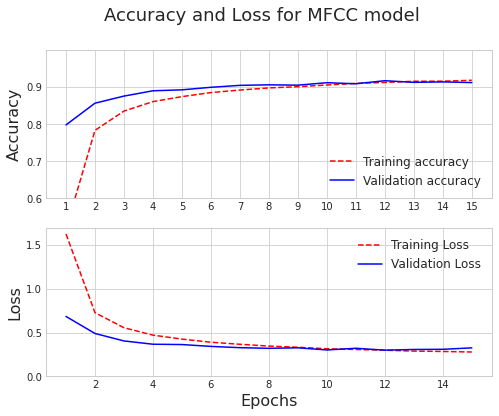

In [91]:
plt.clf()
fig, ax = plt.subplots(2, figsize=(8,6))
fig.suptitle("Accuracy and Loss for MFCC model", fontsize=18)
ax[0].plot(epochsM, accM, '--r', label='Training accuracy')
ax[0].plot(epochsM, valAccM, 'b', label='Validation accuracy')
ax[0].set_xticks(epochsM)
ax[0].set_yticks(np.arange(0.0, 1.0, step=0.1))
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim(0.6, 1.0)


ax[1].plot(epochsM, lossM, '--r', label='Training Loss')
ax[1].plot(epochsM, valLossM, 'b', label='Validation Loss')
ax[1].set_yticks(np.arange(0.0, 2.0, step=0.5))
ax[1].set_ylabel("Loss", fontsize=16)
ax[1].set_xlabel("Epochs", fontsize=16)

ax[0].legend(fontsize=12, loc='lower right')
ax[1].legend(fontsize=12, loc='upper right')
plt.show

In [92]:
# Create and compile Raw data model
inputTensorRaw = Input(shape=(trainDataRaw[0].shape))
y = Conv1D(64, 9, padding='same', activation='relu')(inputTensorRaw)
y = Conv1D(64, 9, padding='same', activation='relu')(y)
y = MaxPooling1D((7))(y)
y = Conv1D(128, 9, padding='same', activation='relu')(y)
y = Conv1D(128, 9, padding='same', activation='relu')(y)
y = MaxPooling1D((7))(y)
y = Conv1D(256, 9, padding='same', activation='relu')(y)
y = Conv1D(256, 9, padding='same', activation='relu')(y)
y = MaxPooling1D((5))(y)
y = Flatten()(y)
y = Dropout(0.4)(y)
y = Dense(128, activation='relu')(y)
y = Dropout(0.4)(y)
outputTensorRaw = Dense(33, activation='softmax')(y)

modelR = Model(inputTensorRaw, outputTensorRaw)
modelR.summary()

modelR.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 64)          640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 64)          36928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1142, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1142, 128)         73856     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1142, 128)         147584    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 163, 128)          0   

In [93]:
# Fit Raw wave model
historyR = modelR.fit(trainDataRaw,
          trainLabels,
          epochs=15,
          batch_size=128,
          validation_data=(validationDataRaw, validationLabels))

Epoch 1/15
636/636 [==============================] - 119s 187ms/step - loss: 2.0806 - accuracy: 0.3909 - val_loss: 0.8898 - val_accuracy: 0.7320
Epoch 2/15
636/636 [==============================] - 119s 186ms/step - loss: 0.9042 - accuracy: 0.7308 - val_loss: 0.5398 - val_accuracy: 0.8358
Epoch 3/15
636/636 [==============================] - 119s 187ms/step - loss: 0.6568 - accuracy: 0.8046 - val_loss: 0.4480 - val_accuracy: 0.8688
Epoch 4/15
636/636 [==============================] - 119s 187ms/step - loss: 0.5450 - accuracy: 0.8355 - val_loss: 0.3966 - val_accuracy: 0.8834
Epoch 5/15
636/636 [==============================] - 119s 187ms/step - loss: 0.4787 - accuracy: 0.8569 - val_loss: 0.3713 - val_accuracy: 0.8874
Epoch 6/15
636/636 [==============================] - 119s 187ms/step - loss: 0.4330 - accuracy: 0.8699 - val_loss: 0.3522 - val_accuracy: 0.8958
Epoch 7/15
636/636 [==============================] - 119s 187ms/step - loss: 0.3936 - accuracy: 0.8806 - val_loss: 0.3410 -

In [94]:
resultsR = modelR.evaluate(testDataRaw, testLabels)

318/318 [==============================] - 5s 16ms/step - loss: 0.3127 - accuracy: 0.9134


In [95]:
# Prepare performance graph, Raw wave
plt.style.use('seaborn-whitegrid')
historyDictR = historyR.history
lossR = historyDictR['loss']
valLossR = historyDictR['val_loss']
accR = historyDictR['accuracy']
valAccR = historyDictR['val_accuracy']
epochsR = range(1, len(lossR) + 1)

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 432x288 with 0 Axes>

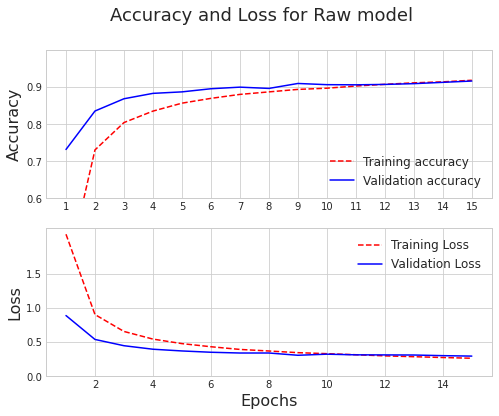

In [96]:
plt.clf()
fig, ax = plt.subplots(2, figsize=(8,6))
fig.suptitle("Accuracy and Loss for Raw model", fontsize=18)
ax[0].plot(epochsR, accR, '--r', label='Training accuracy')
ax[0].plot(epochsR, valAccR, 'b', label='Validation accuracy')
ax[0].set_xticks(epochsR)
ax[0].set_yticks(np.arange(0.0, 1.0, step=0.1))
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim(0.6, 1.0)

ax[1].plot(epochsR, lossR, '--r', label='Training Loss')
ax[1].plot(epochsR, valLossR, 'b', label='Validation Loss')
ax[1].set_yticks(np.arange(0.0, 2.0, step=0.5))
ax[1].set_ylabel("Loss", fontsize=16)
ax[1].set_xlabel("Epochs", fontsize=16)

ax[0].legend(fontsize=12, loc='lower right')
ax[1].legend(fontsize=12, loc='upper right')
plt.show

In [104]:
# Create and compile combined model
# MFCC branch
inputTensorMfcc = Input(shape=(trainDataMfcc[0].shape), name='MFCC')
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(inputTensorMfcc)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D((2 ,2))(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D((2 ,2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# Raw wave branch
inputTensorRaw = Input(shape=(trainDataRaw[0].shape), name='RawWave')
y = Conv1D(64, 9, padding='same', activation='relu')(inputTensorRaw)
y = Conv1D(64, 9, padding='same', activation='relu')(y)
y = MaxPooling1D((7))(y)
y = Conv1D(128, 9, padding='same', activation='relu')(y)
y = Conv1D(128, 9, padding='same', activation='relu')(y)
y = MaxPooling1D((7))(y)
y = Conv1D(256, 9, padding='same', activation='relu')(y)
y = Conv1D(256, 9, padding='same', activation='relu')(y)
y = MaxPooling1D((5))(y)
y = Flatten()(y)
y = Dropout(0.4)(y)
y = Dense(128, activation='relu')(y)
y = Dropout(0.4)(y)

concatenated = concatenate([x, y], axis=-1)

outputTensor = Dense(33, activation='softmax')(concatenated)

modelC = Model([inputTensorMfcc, inputTensorRaw], outputTensor)
modelC.summary()

modelC.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MFCC (InputLayer)               [(None, 20, 45, 1)]  0                                            
__________________________________________________________________________________________________
RawWave (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 18, 43, 64)   640         MFCC[0][0]                       
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 8000, 64)     640         RawWave[0][0]                    
____________________________________________________________________________________________

In [105]:
# Fit combined model
historyC = modelC.fit([trainDataMfcc, trainDataRaw],
          trainLabels,
          epochs=15,
          batch_size=128,
          validation_data=([validationDataMfcc, validationDataRaw], validationLabels))

Epoch 1/15
636/636 [==============================] - 128s 202ms/step - loss: 1.7240 - accuracy: 0.4988 - val_loss: 0.7001 - val_accuracy: 0.7845
Epoch 2/15
636/636 [==============================] - 128s 202ms/step - loss: 0.6947 - accuracy: 0.7881 - val_loss: 0.4356 - val_accuracy: 0.8672
Epoch 3/15
636/636 [==============================] - 128s 202ms/step - loss: 0.5002 - accuracy: 0.8477 - val_loss: 0.3476 - val_accuracy: 0.8946
Epoch 4/15
636/636 [==============================] - 129s 202ms/step - loss: 0.4076 - accuracy: 0.8744 - val_loss: 0.3234 - val_accuracy: 0.9007
Epoch 5/15
636/636 [==============================] - 129s 202ms/step - loss: 0.3509 - accuracy: 0.8928 - val_loss: 0.2868 - val_accuracy: 0.9120
Epoch 6/15
636/636 [==============================] - 129s 202ms/step - loss: 0.3090 - accuracy: 0.9047 - val_loss: 0.2689 - val_accuracy: 0.9188
Epoch 7/15
636/636 [==============================] - 129s 202ms/step - loss: 0.2806 - accuracy: 0.9125 - val_loss: 0.2742 -

In [106]:
resultsC = modelC.evaluate([testDataMfcc, testDataRaw], testLabels)

318/318 [==============================] - 5s 16ms/step - loss: 0.2640 - accuracy: 0.9251


In [107]:
# Prepare performance graph, Combined model
plt.style.use('seaborn-whitegrid')
historyDictC = historyC.history
lossC = historyDictC['loss']
valLossC = historyDictC['val_loss']
accC = historyDictC['accuracy']
valAccC = historyDictC['val_accuracy']
epochsC = range(1, len(lossC) + 1)

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 432x288 with 0 Axes>

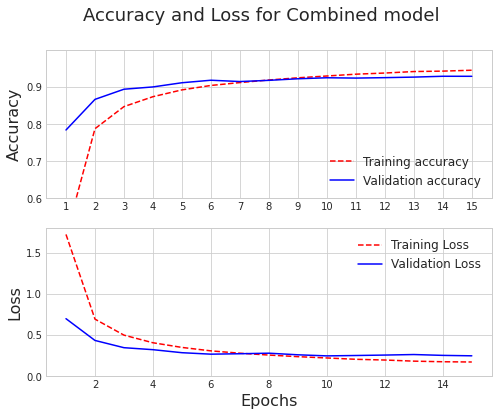

In [108]:
plt.clf()
fig, ax = plt.subplots(2, figsize=(8,6))
fig.suptitle("Accuracy and Loss for Combined model", fontsize=18)
ax[0].plot(epochsC, accC, '--r', label='Training accuracy')
ax[0].plot(epochsC, valAccC, 'b', label='Validation accuracy')
ax[0].set_xticks(epochsC)
ax[0].set_yticks(np.arange(0.0, 1.0, step=0.1))
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim(0.6, 1.0)

ax[1].plot(epochsC, lossC, '--r', label='Training Loss')
ax[1].plot(epochsC, valLossC, 'b', label='Validation Loss')
ax[1].set_yticks(np.arange(0.0, 2.0, step=0.5))
ax[1].set_ylabel("Loss", fontsize=16)
ax[1].set_xlabel("Epochs", fontsize=16)

ax[0].legend(fontsize=12, loc='lower right')
ax[1].legend(fontsize=12, loc='upper right')
plt.show

# Hypothesis testing

In [136]:
# Get predictions from the testset
predictC = modelC.predict([testDataMfcc, testDataRaw])
predictR = modelR.predict(testDataRaw)
predictM = modelM.predict(testDataMfcc)

In [139]:
# One-hot encoded trueLabels to initial format
trueLabels = [np.where(i==1)[0][0] for i in testLabels]
# Get the predicted labels in same format as trueLabels
predictedLabelsC = [np.argmax(i) for i in predictC]
predictedLabelsR = [np.argmax(i) for i in predictR]
predictedLabelsM = [np.argmax(i) for i in predictM]

In [180]:
def contTableMcNemar(trueLabels, table1, table2):
    '''
    Takes truelabels and two tables with predictions and create a McNemar contingency table.
    '''
    contTable = [[0, 0],
                 [0, 0]]
    # Running for C vs R
    for id, trueL in enumerate(trueLabels):
        if trueL == table1[id] and trueL == table2[id]:
            contTable[0][0] += 1
        elif trueL == table1[id] and trueL != table2[id]:
            contTable[0][1] += 1
        elif trueL != table1[id] and trueL == table2[id]:
            contTable[1][0] += 1
        elif trueL != table1[id] and trueL != table2[id]:
            contTable[1][1] += 1
        else:
            print("Error")
    return contTable

In [206]:
def calcMcNemarStatistic(contTable):
    return mcnemar(contTable, exact=False, correction=False)

In [181]:
contTableCR = contTableMcNemar(trueLabels, predictedLabelsC, predictedLabelsR)
contTableCM = contTableMcNemar(trueLabels, predictedLabelsC, predictedLabelsM)

In [207]:
# Calculating the mcnemar test
# Combined model vs Raw wave model
print(contTableCR)
print(calcMcNemarStatistic(contTableCR))
# Combined model vs MFCC model
print(contTableCM)
print(calcMcNemarStatistic(contTableCM))

[[8977, 429], [310, 451]]
pvalue      1.2005620115534358e-05
statistic   19.16238159675237
[[8987, 419], [279, 482]]
pvalue      1.1638881387815285e-07
statistic   28.08022922636103


In [145]:
cmC = tf.math.confusion_matrix(trueLabels, predictedLabelsC, num_classes=None, dtype=tf.dtypes.int32)
cmR = tf.math.confusion_matrix(trueLabels, predictedLabelsR, num_classes=None, dtype=tf.dtypes.int32)
cmM = tf.math.confusion_matrix(trueLabels, predictedLabelsM, num_classes=None, dtype=tf.dtypes.int32)